# Models: distilbert-base-uncased


In [1]:
# !pip install datasets
# !pip install emoji

In [2]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import sys
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import gc
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [5]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
    else:
        print("CUDA is not available. Using CPU.")

check_cuda()

CUDA is available. Using GPU: NVIDIA A100-SXM4-40GB


In [6]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

### Step 1: Importing necessary libraries

In [7]:
 !pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00


In [8]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
from huggingface_hub import login

# wandb library
import wandb
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib
import ast
from pprint import pprint

#### Setting up directory for the files

In [9]:
import os
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the working directory to the NLP folder in your Drive
nlp_folder = Path('/content/drive/My Drive/NLP')
os.chdir(nlp_folder)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Define the base path (now the NLP folder)
basepath = nlp_folder

# Create the data folder, model folder, and custom functions folder
data_folder = Path(basepath) / 'data_folder/'
model_folder = Path(basepath) / 'lect 7' / 'assignment 6'/ 'sentiment' / 'nn' # Updated path
custom_functions = Path(basepath) / 'lect 7' / 'assignment 6' /'CustomFiles'  # Updated path

# Create the necessary directories if they don't exist
model_folder.mkdir(exist_ok=True, parents=True)
custom_functions.mkdir(exist_ok=True, parents=True)

# Verify that the folders are created
print(f"Model folder created: {model_folder.exists()}")
print(f"Custom functions folder created: {custom_functions.exists()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/NLP
Model folder created: True
Custom functions folder created: True


In [10]:
import wandb

# Log into WandB
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
# !pip install huggingface_hub

In [12]:
# pip install ipywidgets

In [13]:
from huggingface_hub import login

login()

### Step 2: Load Data and preprocessing

In [14]:
# Read in the Training and Testing Dataset

train_df = pd.read_csv(data_folder/'train.csv')
test_df = pd.read_csv(data_folder/'test.csv')

In [15]:
train_df.head(3)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0


In [16]:
# Print the second tweet
print(train_df['Tweet'].values[1])

Whatever you decide to do make sure it makes you #happy.


In [17]:
pprint(train_df['Tweet'].values[1], width=80)

'Whatever you decide to do make sure it makes you #happy.'


In [18]:
train_df.shape

(7724, 13)

In [19]:
train_df.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

anger           2859
anticipation    1102
disgust         2921
fear            1363
joy             2877
love             832
optimism        2291
pessimism        895
sadness         2273
surprise         396
trust            400
dtype: int64


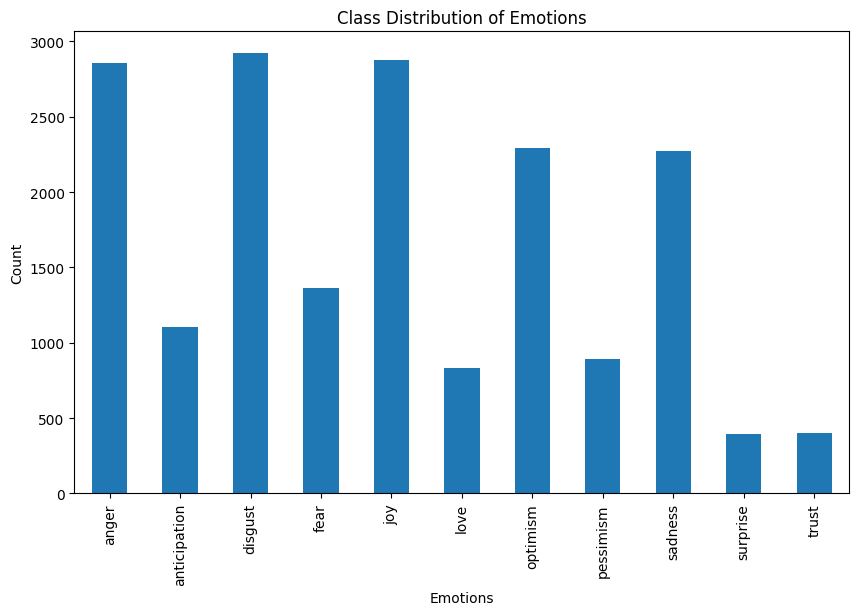

In [20]:
# List of emotion labels
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Sum each column to get the count of 1s (positive examples) for each emotion
class_distribution = train_df[labels].sum()

# Display the class distribution
print(class_distribution)

# Optionally, you can plot the distribution using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [21]:
# Check for null values in train_df
null_values_train = train_df.isnull().sum()

# Check for null values in df_test
null_values_test = test_df.isnull().sum()

# Display the results
print("Null values in train_df:\n", null_values_train)
print("\nNull values in df_test:\n", null_values_test)

Null values in train_df:
 ID              0
Tweet           0
anger           0
anticipation    0
disgust         0
fear            0
joy             0
love            0
optimism        0
pessimism       0
sadness         0
surprise        0
trust           0
dtype: int64

Null values in df_test:
 ID              0
Tweet           0
anger           0
anticipation    0
disgust         0
fear            0
joy             0
love            0
optimism        0
pessimism       0
sadness         0
surprise        0
trust           0
dtype: int64


In [23]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.2 MB/s eta 0:00:00


In [24]:
import re
import spacy
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
import emoji
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess_tweet(tweet, lemmatize=True, lower=True, remove_stop=True,
                     remove_punct=True, remove_num=False, remove_url=True,
                     remove_mentions=True, remove_emoji=True, remove_hashtags=False):
    """
    Preprocesses a tweet by applying various cleaning steps:
    - Lemmatization
    - Lowercasing
    - Stopword, punctuation, URL, number, and mention removal
    - Emoji and hashtag handling

    Parameters:
    - lemmatize: Whether to apply lemmatization using Spacy.
    - lower: Whether to lowercase the tweet.
    - remove_stop: Whether to remove stopwords.
    - remove_punct: Whether to remove punctuation.
    - remove_num: Whether to remove numbers.
    - remove_url: Whether to remove URLs.
    - remove_mentions: Whether to remove @mentions.
    - remove_emoji: Whether to remove emojis.
    - remove_hashtags: Whether to remove the hashtag symbol (#) but keep the word.

    Returns:
    - Cleaned tweet as a string.
    """
    try:
        # Basic cleanup: remove URLs, mentions, and special characters
        if remove_url:
            tweet = re.sub(r"http\S+|www\S+", "", tweet)
        if remove_mentions:
            tweet = re.sub(r"@\w+", "", tweet)

        # Optionally remove emojis
        if remove_emoji:
            tweet = emoji.replace_emoji(tweet, replace='')

        # Optionally remove hashtags but keep the word
        if remove_hashtags:
            tweet = re.sub(r"#", "", tweet)

        # Remove HTML tags if present
        soup = BeautifulSoup(tweet, "html.parser")
        tweet = soup.get_text()

        # Tokenize the tweet
        tokenizer = TweetTokenizer()
        tokens = tokenizer.tokenize(tweet)

        # Use spaCy for lemmatization and stopword/punctuation/number filtering
        doc = nlp(" ".join(tokens))
        cleaned_tokens = []
        for token in doc:
            if remove_stop and token.is_stop:
                continue
            if remove_punct and token.is_punct:
                continue
            if remove_num and token.like_num:
                continue
            if lemmatize:
                cleaned_tokens.append(token.lemma_)
            else:
                cleaned_tokens.append(token.text)

        # Join tokens back into a single string
        cleaned_tweet = " ".join(cleaned_tokens)

        # Optionally lowercase the tweet
        if lower:
            cleaned_tweet = cleaned_tweet.lower()

        return cleaned_tweet.strip()

    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

In [25]:
# # Apply preprocessing to each tweet
# train_df['cleaned_tweet'] = train_df['Tweet'].apply(preprocess_tweet)
# # Apply preprocessing to each tweet
# test_df['cleaned_tweet'] = test_df['Tweet'].apply(preprocess_tweet)
# print(train_df[['Tweet', 'cleaned_tweet']])

# Apply the updated preprocess_tweet function to each tweet in the training set
train_df['cleaned_tweet'] = train_df['Tweet'].apply(lambda x: preprocess_tweet(x,
                                                                               lemmatize=True,
                                                                               lower=True,
                                                                               remove_stop=True,
                                                                               remove_punct=True,
                                                                               remove_num=False,
                                                                               remove_url=True,
                                                                               remove_mentions=True,
                                                                               remove_emoji=True,
                                                                               remove_hashtags=False))

# Apply the updated preprocess_tweet function to each tweet in the test set
test_df['cleaned_tweet'] = test_df['Tweet'].apply(lambda x: preprocess_tweet(x,
                                                                             lemmatize=True,
                                                                             lower=True,
                                                                             remove_stop=True,
                                                                             remove_punct=True,
                                                                             remove_num=False,
                                                                             remove_url=True,
                                                                             remove_mentions=True,
                                                                             remove_emoji=True,
                                                                             remove_hashtags=False))

# Display original and cleaned tweets for comparison
print(train_df[['Tweet', 'cleaned_tweet']].head())


<ipython-input-24-079592fc4e27>:51: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(tweet, "html.parser")
<ipython-input-24-079592fc4e27>:51: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(tweet, "html.parser")


                                               Tweet  \
0  “Worry is a down payment on a problem you may ...   
1  Whatever you decide to do make sure it makes y...   
2  @Max_Kellerman  it also helps that the majorit...   
3  Accept the challenges so that you can literall...   
4  My roommate: it's okay that we can't spell bec...   

                                       cleaned_tweet  
0  worry payment problem joyce meyer motivation l...  
1                             decide sure make happy  
2  help majority nfl coaching inept bill o'brien ...  
3  accept challenge literally feel exhilaration v...  
4  roommate okay spell autocorrect terrible first...  


In [26]:
# Step 1: Identify the label columns (all columns except 'ID' and 'Tweet')
emotion_columns = [col for col in train_df.columns if col not in ['ID', 'Tweet','cleaned_tweet']]

# Step 2: Split the train_df into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df['cleaned_tweet'], train_df[emotion_columns], test_size=0.2, random_state=42)

# X_train, X_valid, y_train, y_valid = train_test_split(
#     train_df['Tweet'], train_df[emotion_columns], test_size=0.2, random_state=42)



In [27]:
# Function to convert label row to binary vector
def convert_labels_to_vector(label_row):
    # Create a binary vector for the labels
    return [1 if label != 'NONE' else 0 for label in label_row]

# Step 3: Prepare the test data (use test_df['cleaned_tweet'] and test_df[label_columns])
X_test = test_df['cleaned_tweet'].tolist()
# X_test = test_df['Tweet'].tolist()
y_test = test_df[emotion_columns].apply(convert_labels_to_vector, axis=1).values.tolist()

# Convert X_train, X_valid, and X_test to lists, and the corresponding labels to lists of lists
X_train = X_train.tolist()
y_train = y_train.values.tolist()

X_valid = X_valid.tolist()
y_valid = y_valid.values.tolist()



In [28]:
from datasets import Dataset, DatasetDict
import pandas as pd

In [29]:
# Step 4: Create trainset, validset, and testset using Dataset.from_dict
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_valid,
    'labels': y_valid
})

testset = Dataset.from_dict({
    'texts': X_test,
    'labels': y_test
})

# Define the label columns
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Function to transform each Dataset to the desired format
def transform_dataset(dataset):
    df = dataset.to_pandas()
    # df.insert(0, 'ID', range(1, len(df) + 1))  # Add ID column
    df = df.rename(columns={'texts': 'Tweet'})  # Rename 'texts' to 'Tweet'

    # Convert the 'labels' column to individual label columns
    labels_df = pd.DataFrame(df['labels'].tolist(), columns=label_columns)
    df = pd.concat([df[['Tweet']], labels_df], axis=1)

    # Convert back to Hugging Face Dataset
    return Dataset.from_pandas(df)

# Transform each dataset and create DatasetDict
dataset_dict = DatasetDict({
    "train": transform_dataset(trainset),
    "validation": transform_dataset(validset),
    "test": transform_dataset(testset)
})

# Check the final structure
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6179
    })
    validation: Dataset({
        features: ['Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 1545
    })
    test: Dataset({
        features: ['Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
})


In [30]:
dataset_dict['train'][1:5]

{'Tweet': ['know band world glad ask muchlove',
  'unruly kid 8 morning nothank rip flower bed root parent watch shocking',
  'ok get call white devil train not know laugh offend',
  'wrong need levity recording'],
 'anger': [0, 1, 0, 1],
 'anticipation': [0, 0, 0, 0],
 'disgust': [0, 1, 0, 1],
 'fear': [0, 1, 1, 0],
 'joy': [1, 0, 0, 0],
 'love': [1, 0, 0, 0],
 'optimism': [1, 0, 0, 0],
 'pessimism': [0, 0, 0, 0],
 'sadness': [0, 0, 0, 0],
 'surprise': [0, 1, 1, 0],
 'trust': [0, 0, 0, 0]}

In [32]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [33]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [34]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Define the weighted loss function
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.class_weights.to(logits.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [35]:
# !pip install optuna

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import torch
from transformers import EvalPrediction
import optuna
from datetime import date
from sklearn.metrics import multilabel_confusion_matrix

class MultiLabelClassifier:
    def __init__(self, model_name, labels, batch_size=8, learning_rate=2e-5, num_epochs=5, metric_name="f1", threshold=0.5):
        """
        Initializes the MultiLabelClassifier.

        Args:
        - model_name (str): The pre-trained model name.
        - labels (list of str): The list of labels for classification.
        - batch_size (int): Batch size for training.
        - learning_rate (float): Learning rate for training.
        - num_epochs (int): Number of epochs for training.
        - metric_name (str): The name of the evaluation metric.
        - threshold (float): Threshold for binary classification.

        Returns:
        - None
        """
        self.model_name = model_name
        self.labels = labels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.metric_name = metric_name
        self.threshold = threshold
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, problem_type="multi_label_classification", num_labels=len(labels), id2label={str(i): label for i, label in enumerate(labels)}, label2id={label: i for i, label in enumerate(labels)})
        self.id2label = {str(i): label for i, label in enumerate(labels)}
        self.label2id = {label: i for i, label in enumerate(labels)}
        self.model.to(self.device)

    def preprocess_data(self, examples):
        """
        Preprocesses the input data.

        Args:
        - examples (dict): Dictionary containing input data.

        Returns:
        - dict: Preprocessed input data.
        """
        text = examples["Tweet"]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=128)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))
        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]
        encoding["labels"] = labels_matrix.tolist()
        return encoding


    # def calculate_class_weights(self, train_dataset):
    #     """
    #     Calculates inverse frequency class weights for each label in the dataset.

    #     Args:
    #     - train_dataset: Dataset object containing the training data.

    #     Returns:
    #     - torch.Tensor: Class weights tensor.
    #     """
    #     # Count occurrences of each label in the dataset
    #     label_counts = np.zeros(len(self.labels))
    #     for example in train_dataset:
    #         for i, label in enumerate(self.labels):
    #             if example[label] == 1:
    #                 label_counts[i] += 1

    #     # Calculate weights as the inverse of label frequency
    #     class_weights = 1.0 / (label_counts + 1e-9)  # Add small value to avoid division by zero
    #     normalized_weights = class_weights / class_weights.sum()  # Normalize

    #     # Convert to tensor for use in PyTorch
    #     return torch.tensor(normalized_weights, dtype=torch.float)

    def calculate_class_weights(self, train_dataset):
      """
      Calculates positive weights for each label in the dataset based on
      the ratio of negative to positive samples for each emotion label.

      Args:
      - train_dataset: Dataset object containing the training data.

      Returns:
      - torch.Tensor: Positive weights tensor.
      """
      # Extract label columns (assume they are the columns after 'ID' and 'Tweet')
      label_columns = train_dataset.column_names[1:]  # Skip 'ID' and 'Tweet'
      total_positives = []
      total_negatives = []

      # Count positives and negatives for each label
      for label in label_columns:
          label_values = train_dataset[label]
          pos_count = sum(label_values)
          neg_count = len(label_values) - pos_count
          total_positives.append(pos_count)
          total_negatives.append(neg_count)

      # Calculate pos_weight for each label
      pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(len(label_columns))]

      # Convert to tensor for use in PyTorch
      return torch.tensor(pos_weight, dtype=torch.float)


    def multi_label_metrics(self, predictions, labels, threshold=None):
        """
        Computes multi-label classification metrics.

        Args:
        - predictions (torch.Tensor): Model predictions.
        - labels (np.ndarray): Ground truth labels.
        - threshold (float): Threshold for binary classification.

        Returns:
        - dict: Dictionary containing computed metrics.
        """
        if threshold is None:
            threshold = self.threshold
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(torch.Tensor(predictions))
        y_pred = np.zeros(probs.shape)
        y_pred[np.where(probs >= threshold)] = 1
        y_true = labels
        f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
        f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, y_pred, average='micro')
        accuracy = accuracy_score(y_true, y_pred)
        metrics = {'f1_micro': f1_micro_average,'f1_macro': f1_macro_average, 'roc_auc': roc_auc, 'accuracy': accuracy}
        return metrics

    def multilabel_confusion_matrix(self, predictions, labels, threshold=None):
        """
        Computes multilabel confusion matrix.

        Args:
        - predictions (torch.Tensor): Model predictions.
        - labels (np.ndarray): Ground truth labels.
        - threshold (float): Threshold for binary classification.

        Returns:
        - np.ndarray: Multilabel confusion matrix.
        """
        if threshold is None:
            threshold = self.threshold
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(torch.Tensor(predictions))
        y_pred = np.zeros(probs.shape)
        y_pred[np.where(probs >= threshold)] = 1
        y_true = labels
        return multilabel_confusion_matrix(y_true, y_pred)

    def compute_metrics(self, p: EvalPrediction):
        """
        Computes evaluation metrics.

        Args:
        - p (EvalPrediction): Evaluation predictions.

        Returns:
        - dict: Dictionary containing computed metrics.
        """
        preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        result = self.multi_label_metrics(predictions=preds, labels=p.label_ids)
        return result

    def train(self, train_dataset, valid_dataset, push_to_huggingface=True):
        """
        Trains the model.

        Args:
        - train_dataset (Dataset): Training dataset.
        - valid_dataset (Dataset): Validation dataset.

        Returns:
        - None
        """
        # Calculate class weights
        class_weights = self.calculate_class_weights(train_dataset).to(self.device)


        args = TrainingArguments(
            f"{self.model_name}-finetuned",
            # evaluation_strategy="epoch",
            # save_strategy="epoch",
            learning_rate=self.learning_rate,
            per_device_train_batch_size=self.batch_size,
            per_device_eval_batch_size=self.batch_size,
            num_train_epochs=self.num_epochs,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",  # Use F1 score as the metric to determine the best model
            optim='adamw_torch',  # Optimizer
            # output_dir=str(model_folder),  # Directory to save model checkpoints
            evaluation_strategy='steps',  # Evaluate model at specified step intervals
            eval_steps=50,  # Perform evaluation every 50 training steps
            save_strategy="steps",  # Save model checkpoint at specified step intervals
            save_steps=1000,  # Save model checkpoint every 1000 training steps
            save_total_limit=2,  # Retain only the best and the most recent model checkpoints
            greater_is_better=True,  # A model is 'better' if its F1 score is higher
            logging_strategy='steps',  # Log metrics and results to Weights & Biases platform
            logging_steps=50,  # Log metrics and results every 50 steps
            report_to='wandb',  # Log metrics and results to Weights & Biases platform
            gradient_accumulation_steps=10,  # Accumulate gradients for every 1 step
            gradient_checkpointing=True,  # Enable gradient checkpointing
            run_name=f"emotion_tweet_{self.model_name}_{date.today().strftime('%Y-%m-%d_%H-%M-%S')}",  # Experiment name for Weights & Biases
            fp16=True  # Use mixed precision training (FP16)
            )

        train_dataset = train_dataset.map(self.preprocess_data, batched=True, remove_columns=train_dataset.column_names)
        valid_dataset = valid_dataset.map(self.preprocess_data, batched=True, remove_columns=valid_dataset.column_names)

        train_dataset.set_format("torch")
        valid_dataset.set_format("torch")

        # trainer = Trainer(
        #     self.model,
        #     args,
        #     train_dataset=train_dataset,
        #     eval_dataset=valid_dataset,
        #     tokenizer=self.tokenizer,
        #     compute_metrics=self.compute_metrics
        # )

        # Set up custom trainer
        trainer = CustomTrainer(
            model=self.model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            tokenizer=self.tokenizer,
            compute_metrics=self.compute_metrics,
            class_weights=class_weights
        )

        trainer.train()
        eval_results = trainer.evaluate()
        print(f"Evaluation results: {eval_results}")

        # Pushing model to Huggingface
        if push_to_huggingface:
          model_name_hf = f"emotion_tweet_{self.model_name}_{date.today().strftime('%Y-%m-%d')}"
          self.model.push_to_hub(model_name_hf)
          print(f"Model pushed to Huggingface: ShobhitPachauri/{model_name_hf}")


        # Log evaluation results to Weights & Biases platform
        wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"], "eval_f1": eval_results["eval_f1_macro"]})

        # # Compute and plot confusion matrix
        # preds = trainer.predict(valid_dataset)
        # y_labels = valid_dataset[self.labels]
        # confusion_matrix = self.multilabel_confusion_matrix(preds, y_labels)
        # plt.figure(figsize=(10, 7))
        # sns.heatmap(confusion_matrix, annot=True, cmap="Blues")
        # plt.xlabel("Predicted Labels")
        # plt.ylabel("True Labels")
        # plt.title("Multilabel Confusion Matrix")
        # plt.show()

        # # Log confusion matrix to Weights & Biases platform
        # wandb.log({"confusion_matrix": wandb.Image(plt)})

    def predict(self, texts, thresholds=None, load_from_huggingface=False):
        """
        Generates predictions for a list of texts in a multilabel setting.

        Args:
        - texts (list of str): List of input texts.
        - thresholds (list or dict): List of threshold values for each label in order,
                                    or a dictionary with label names as keys.

        Returns:
        - list: List of lists containing predicted labels for each input text.
        - numpy array: Binary prediction array.
        """
        # Verify thresholds are provided
        if thresholds is None:
            raise ValueError("Please provide a list or dictionary of thresholds for each label.")

        # If thresholds are passed as a list, convert to a tensor
        if isinstance(thresholds, list):
            thresholds_tensor = torch.tensor(thresholds, device=self.device)
        elif isinstance(thresholds, dict):
            thresholds_tensor = torch.tensor(
                [thresholds[label] for label in self.labels], device=self.device
            )
        else:
            raise ValueError("Thresholds should be either a list or a dictionary.")

        # Load the model from Hugging Face if specified
        if load_from_huggingface:
            self.model = AutoModelForSequenceClassification.from_pretrained(load_from_huggingface)
            self.model.to(self.device)
        else:
            self.model.to(self.device)

        # Preprocess input texts
        encoding = self.tokenizer(
            texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
        ).to(self.device)

        # Make predictions
        with torch.no_grad():
            output = self.model(**encoding)

        # Convert logits to probabilities
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(output.logits)

        # Apply individual thresholds for each label
        binary_preds = (probs >= thresholds_tensor).int()

        # Convert binary predictions to label names
        label_preds = []
        for pred in binary_preds:
            label_pred = [self.id2label[str(i)] for i, val in enumerate(pred) if val == 1]
            label_preds.append(label_pred)

        return label_preds, binary_preds.cpu().numpy()


    def optimize_threshold(self, valid_dataset):
        """
        Optimizes the threshold for multilabel classification.

        Args:
        - valid_dataset (Dataset): Validation dataset.

        Returns:
        - dict: Best threshold values for each label.
        """
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: self.objective(trial, valid_dataset), n_trials=10)

        # Store best threshold values for each label
        self.thresholds = {label: study.best_params[f"threshold_{label}"] for label in self.labels}
        return self.thresholds

    def objective(self, trial, valid_dataset):
        """
        Objective function for threshold optimization.

        Args:
        - trial (optuna.Trial): Optuna trial object.
        - valid_dataset (Dataset): Validation dataset.

        Returns:
        - float: Score for the current set of thresholds.
        """
        # Suggest a threshold for each emotion label in the dataset
        thresholds = {
            label: trial.suggest_float(f"threshold_{label}", 0.0, 1.0)
            for label in valid_dataset.column_names if label != "Tweet"
        }

        # Evaluate the model using the suggested thresholds
        predictions, _ = self.predict(valid_dataset['Tweet'], thresholds=thresholds)
        score = self.evaluate(predictions, valid_dataset)
        return score

    def evaluate(self, predictions, valid_dataset):
        """
        Evaluates the predictions against the ground truth labels in the validation dataset.

        Args:
        - predictions (list of lists): Predicted labels for each input text.
        - valid_dataset (Dataset): Validation dataset containing the ground truth labels.

        Returns:
        - float: F1 score averaged across all labels.
        """
        # Extract ground truth labels for each label column
        ground_truth = valid_dataset.to_pandas()[self.labels].values

        # Convert predictions to binary format (1 if label is predicted, 0 otherwise)
        binary_predictions = []
        for pred in predictions:
            binary_pred = [1 if label in pred else 0 for label in self.labels]
            binary_predictions.append(binary_pred)

        # Compute F1 score (macro or micro, depending on your preference)
        score = f1_score(ground_truth, binary_predictions, average='macro')

        return score

In [37]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

# DataFrame `train_df` with your labels
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Initialize an empty list to store the class weights
class_weights = []

# Loop through each label column to compute the class weights
for column in label_columns:
    y = train_df[column].values  # Extract the binary labels for each emotion
    # Change: Convert classes to a NumPy array
    class_weight = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y)
    class_weights.append(class_weight[1])  # Append weight for class 1 (positive class)

# Convert the list of class weights to a 1D tensor
class_weights_tensor = torch.tensor(class_weights).float()

# Print the final class weights tensor
print(class_weights_tensor)

tensor([1.3508, 3.5045, 1.3221, 2.8335, 1.3424, 4.6418, 1.6857, 4.3151, 1.6991,
        9.7525, 9.6550])


In [66]:
classifier = MultiLabelClassifier(
    model_name="distilbert-base-uncased",
    labels=label_columns,
    batch_size=8,
    learning_rate=2e-5,
    num_epochs=5,
    metric_name="f1_micro",
    threshold=0.5
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
classifier.train(dataset_dict['train'], dataset_dict['validation'], push_to_huggingface=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Roc Auc,Accuracy
50,1.073600,1.018966,0.445224,0.422215,0.653377,0.001942
100,0.933100,0.919701,0.497181,0.452389,0.705032,0.002589
150,0.866200,0.880566,0.515502,0.471682,0.721170,0.009061
200,0.816300,0.855853,0.545788,0.490289,0.741965,0.040777
250,0.766600,0.836047,0.553776,0.499563,0.746615,0.049191
300,0.752100,0.829796,0.559677,0.507462,0.749593,0.060194
350,0.734700,0.825315,0.558177,0.506286,0.747788,0.058252


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

Evaluation results: {'eval_loss': 0.8281618356704712, 'eval_f1_micro': 0.5646507839543881, 'eval_f1_macro': 0.5098463787974752, 'eval_roc_auc': 0.7527406650052642, 'eval_accuracy': 0.06019417475728155, 'eval_runtime': 2.0723, 'eval_samples_per_second': 745.564, 'eval_steps_per_second': 93.618, 'epoch': 4.980595084087969}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model pushed to Huggingface: ShobhitPachauri/emotion_tweet_distilbert-base-uncased_2024-10-30


In [68]:
best_threshold = classifier.optimize_threshold(dataset_dict['validation'])
print(f"Best threshold: {best_threshold}")

[I 2024-10-30 07:56:57,379] A new study created in memory with name: no-name-6e652974-4c56-4aee-ba51-82500fd288b3
[I 2024-10-30 07:56:58,202] Trial 0 finished with value: 0.4063404670162117 and parameters: {'threshold_anger': 0.8233159338139594, 'threshold_anticipation': 0.33685550007197396, 'threshold_disgust': 0.6859860202368366, 'threshold_fear': 0.5278467066010915, 'threshold_joy': 0.9575745998803122, 'threshold_love': 0.5093877657385658, 'threshold_optimism': 0.31257537772071387, 'threshold_pessimism': 0.47739487160279026, 'threshold_sadness': 0.14116804747871403, 'threshold_surprise': 0.3679468575346936, 'threshold_trust': 0.6416796022009666}. Best is trial 0 with value: 0.4063404670162117.
[I 2024-10-30 07:56:58,986] Trial 1 finished with value: 0.49295651115725714 and parameters: {'threshold_anger': 0.5594320777305669, 'threshold_anticipation': 0.4573941775429132, 'threshold_disgust': 0.7003848911461413, 'threshold_fear': 0.5544182362294072, 'threshold_joy': 0.7140260907091386,

Best threshold: {'anger': 0.5594320777305669, 'anticipation': 0.4573941775429132, 'disgust': 0.7003848911461413, 'fear': 0.5544182362294072, 'joy': 0.7140260907091386, 'love': 0.5497750519480467, 'optimism': 0.33550096973355503, 'pessimism': 0.6424264679377817, 'sadness': 0.336816655913298, 'surprise': 0.943609871535349, 'trust': 0.7381247648592947}


In [69]:
# specify the project name where the experiment will be logged
%env WANDB_PROJECT = nlp_course_fall_2024-emotion-classification-hf-distilbert-base-uncased

env: WANDB_PROJECT=nlp_course_fall_2024-emotion-classification-hf-distilbert-base-uncased


In [71]:
wandb.init()

In [72]:
free_memory()

In [73]:
testset = Dataset.from_dict({
    'Tweet': test_df['cleaned_tweet']})

In [74]:
testset

Dataset({
    features: ['Tweet'],
    num_rows: 3259
})

In [75]:
testset[0:10]

{'Tweet': ['not worry indian army way dispatch terrorists hell',
  'academy sciences eschew normally sober tone scientific paper call massive loss wildlife biological annihilation',
  'blow opportunity mad',
  'time 2 week 30',
  'deppression real partner w depressed people truly not understand depth affect add anxiety make bad',
  'interesting choice word confirm government fund terrorism bit open door',
  'cnn sure',
  'distance stretch friend impose loveyou notseriously',
  'happy confident kind n n kissableslovesmshopmag nalloutdenimfor kissmarc',
  'visit hospital care trigger trauma accident 20 + yr ago image dead brother feel symptom depression']}

In [77]:
outputs, outputs_array = classifier.predict(testset['Tweet'], thresholds = best_threshold,load_from_huggingface='ShobhitPachauri/emotion_tweet_distilbert-base-uncased_2024-10-30')


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [78]:
outputs[:10]

[['anger', 'disgust', 'fear', 'sadness'],
 ['anger', 'disgust', 'fear', 'sadness'],
 ['anger', 'disgust', 'sadness'],
 ['anticipation', 'optimism', 'sadness'],
 ['fear', 'pessimism', 'sadness'],
 ['anger', 'anticipation', 'fear', 'sadness'],
 ['anticipation', 'joy', 'optimism'],
 ['joy', 'love', 'optimism'],
 ['joy', 'love', 'optimism'],
 ['fear', 'pessimism', 'sadness']]

In [79]:
outputs_array[:10]

array([[1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]], dtype=int32)

In [80]:
test_df[label_columns] = outputs_array

In [81]:
submission = test_df.drop(columns = ['Tweet','cleaned_tweet'])
submission.head(15)

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,1,0,0,0,0,1,0,0
1,2018-03739,1,0,1,1,0,0,0,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,0,1,0,0,0,0,1,0,1,0,0
4,2018-01988,0,0,0,1,0,0,0,1,1,0,0
5,2018-03463,1,1,0,1,0,0,0,0,1,0,0
6,2018-04315,0,1,0,0,1,0,1,0,0,0,0
7,2018-01426,0,0,0,0,1,1,1,0,0,0,0
8,2018-03332,0,0,0,0,1,1,1,0,0,0,0
9,2018-01938,0,0,0,1,0,0,0,1,1,0,0


In [85]:
model_folder = '/content/drive/My Drive/NLP/models'

In [87]:
submission.to_csv(model_folder + '/' + f'{classifier.model_name}_{date.today()}.csv', index = False)
